## Overview
- Tensor and basics operations
- Variables

In [15]:
import tensorflow as tf
import numpy as np


In [4]:
tensor_ex = tf.constant([1,2,3,4]) # tensor from python list
tensor_ex

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 2, 3, 4], dtype=int32)>

In [7]:
tensor_ex.shape, tensor_ex.ndim

(TensorShape([4]), 1)

### Auto differenciation

In [26]:
x = tf.Variable(1.0) # tensor value rank 0
z = tf.Variable(np.arange(0,27,))

def f(x): # f(x)
  y = x**2 + 2*x - 5
  return y

z = tf.reshape(z, shape = (3,3,3))

In [34]:
with tf.GradientTape(persistent=True) as tape:
  y = f(x) # get y
  y2= f(z)


g_x = tape.gradient(y, x)  # g(x) = dy/dx calculete the derivative of f(x)
g_z = tape.gradient(y2, z)

y2


<tf.Tensor: shape=(3, 3, 3), dtype=int64, numpy=
array([[[ -5,  -2,   3],
        [ 10,  19,  30],
        [ 43,  58,  75]],

       [[ 94, 115, 138],
        [163, 190, 219],
        [250, 283, 318]],

       [[355, 394, 435],
        [478, 523, 570],
        [619, 670, 723]]])>

## Graphs and tf.function provide:


- Performance optimization: to speed up training and inference.
- Export: so you can save your model when it's done training.


These captured graphs provide two benefits:

- In many cases they provide a significant speedup in execution (though not this trivial example).
- You can export these graphs, using tf.saved_model, to run on other systems like a server or a mobile device, no Python installation required.


## Modules, layers, and models

- tf.Module is a class to help manager your tf.Variables

In [36]:
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.Variable(value)

  @tf.function # a python  function that will be turned into tf graph
  def multiply(self, x):
    return x * self.weight


In [39]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))


save_path = './saved'
tf.saved_model.save(mod, save_path)


In [45]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1, 2, 3]))



<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

## Training loops

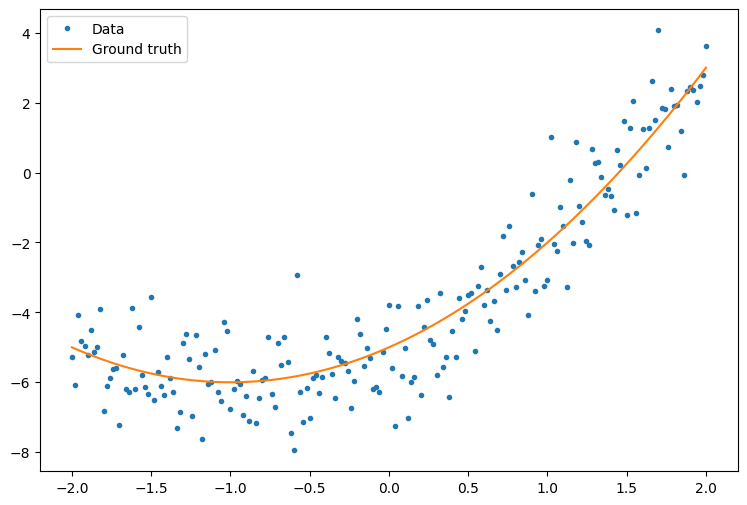

In [47]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();


In [59]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])

  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b


In [67]:
quad_model = Model()

def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()


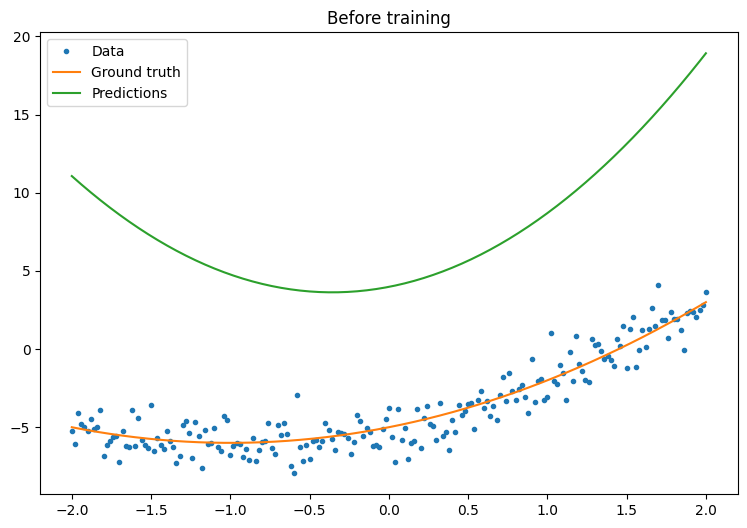

In [69]:
plot_preds(x, y, f, quad_model, 'Before training')

In [74]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))


In [89]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y)) # slice on the first dimension for each given tensor
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size) # divide the combined slices on 32 batches


list(dataset.as_numpy_iterator())[0]

(array([-1.52,  1.86, -1.5 ,  1.32, -1.48,  1.42,  1.14,  0.5 , -1.12,
        -0.82,  0.44,  1.24, -0.7 , -0.38, -0.56,  1.36, -1.38, -0.18,
        -0.42, -1.86,  1.92,  1.04,  0.24,  0.86, -0.66, -0.48, -0.74,
        -1.92,  0.98,  0.3 , -0.96,  1.1 ], dtype=float32),
 array([-6.333335  , -0.0580132 , -3.5612223 ,  0.3139593 , -6.5149107 ,
        -1.069144  , -0.21624756, -3.5154414 , -5.9964976 , -6.438732  ,
        -3.5931973 , -1.9489559 , -4.8708854 , -5.1730843 , -6.274753  ,
        -0.6444036 , -5.8771133 , -4.605809  , -5.860896  , -5.137223  ,
         2.353512  , -2.05543   , -3.6458657 , -3.076534  , -4.707437  ,
        -5.8899164 , -6.3390646 , -4.9716845 , -3.2490606 , -5.800718  ,
        -5.977109  , -1.5300628 ], dtype=float32))

Mean squared error for step 0: 0.948
Mean squared error for step 10: 0.945
Mean squared error for step 20: 0.946
Mean squared error for step 30: 0.945
Mean squared error for step 40: 0.945
Mean squared error for step 50: 0.946
Mean squared error for step 60: 0.946
Mean squared error for step 70: 0.948
Mean squared error for step 80: 0.945
Mean squared error for step 90: 0.947




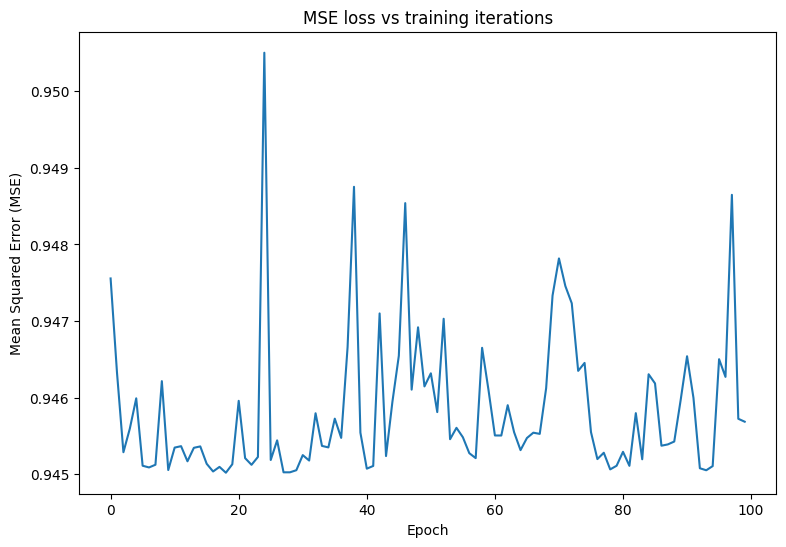

In [96]:
# Set training parameters
epochs = 100 # stage of loop tarining
learning_rate = 0.01 # GD jumps
losses = [] # tracking loss along the training loop

# Format training loop
for epoch in range(epochs):

  for x_batch, y_batch in dataset: # for each batch
    with tf.GradientTape() as tape:
      batch_loss = mse_loss(quad_model(x_batch), y_batch) # calculate loss from the predicted batch
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables) #
    for g,v in zip(grads, quad_model.variables):
        v.assign_sub(learning_rate*g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');


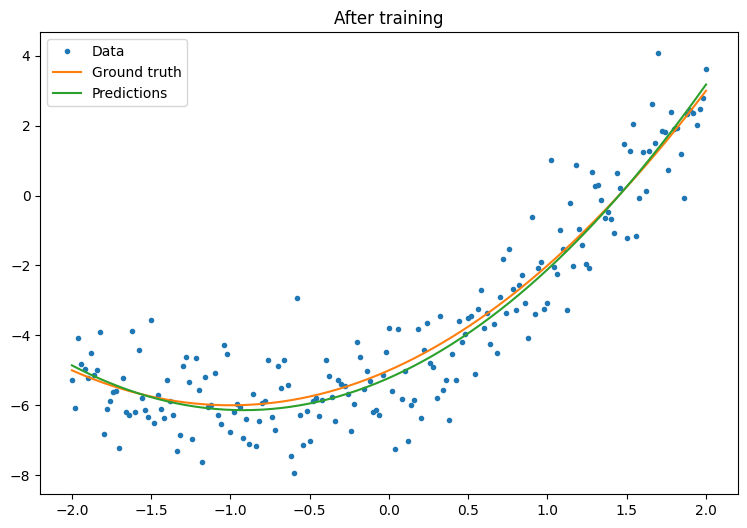

In [94]:
plot_preds(x, y, f, quad_model, 'After training')

## Use builtins Keras Module

In [99]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)])


In [101]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

new_model.save('./my_new_model.keras')


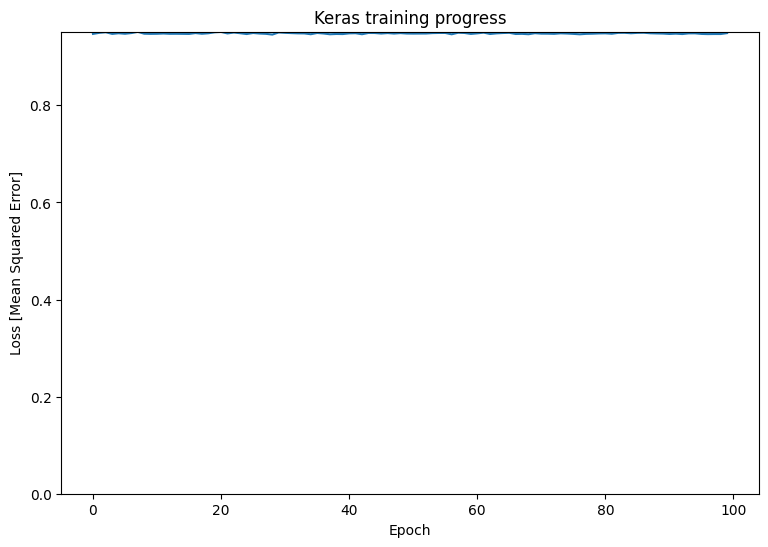

In [102]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');



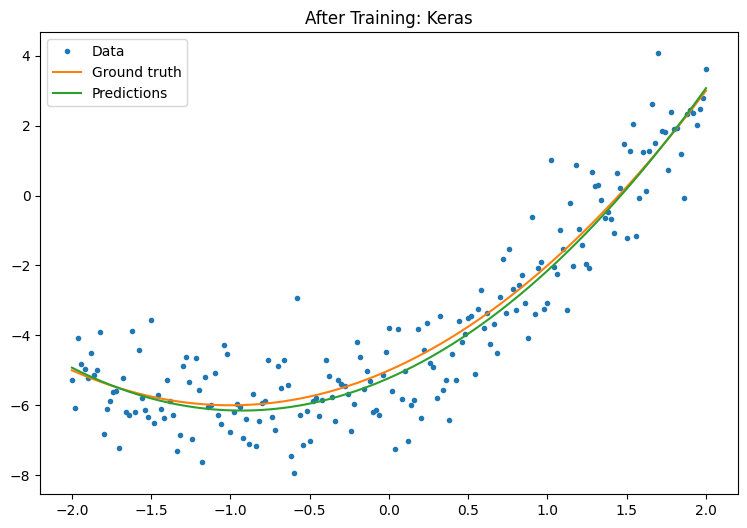

In [103]:
plot_preds(x, y, f, new_model, 'After Training: Keras')
